In [1]:
# Data Loading

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

In [10]:
# KNN Implementation

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import time

In [3]:
def euclidean(x_test, x_train):
    return np.sqrt(np.sum((x_train - x_test)**2,axis=1))

def manhattan(x_test, x_train):
    return np.sum(np.abs(x_train - x_test), axis=1)

In [4]:
class KNearestNeighbors():

    def __init__(self, x_train, y_train, distance=euclidean, k=5):
        self.x_train = x_train
        self.y_train = y_train
        self.distance = euclidean
        self.k = k

    def predict(self, x_test):
        assignments = []
        for x in x_test:
            distances = self.distance(x, self.x_train)
            nearest_indices = np.argsort(distances)
            neighbors = self.y_train[nearest_indices[:self.k]]
            labels, counts = np.unique(neighbors.flatten(),return_counts=True)
            assignments += [labels[np.argmax(counts)]]
        self.y_pred = np.array(assignments)
        return self.y_pred
    
    def f1(self, y_test):
        recall = self.recall(y_test)
        precision = self.recall(y_test)
        return 2 * recall * precision / (precision + recall).clip(1e-8)

    def recall(self, y_test):
        tp = sum((self.y_pred == 'M') & (self.y_pred == y_test))
        fn = sum((self.y_pred == 'M') & (y_test == 'B'))
        return tp / (tp+fn).clip(1e-8)
    
    def precision(self, y_test):
        tp = sum((self.y_pred == 'M') & (self.y_pred == y_test))
        fp = sum((self.y_pred == 'B') & (y_test == 'M'))
        return tp / (tp+fp).clip(1e-8)
    
    def accuracy(self, y_test):
        return sum(self.y_pred == y_test) / len(y_test)
    


In [14]:
# First pass: split 80/20 for train/test

train_set = round(X.shape[0] * 0.8)
x_train = X.values[:train_set]
y_train = y.values[:train_set].flatten()
knn = KNearestNeighbors(x_train,y_train,k=2)

test_set = X.shape[0] - train_set
x_test = X.values[:test_set]
y_test = y.values[:test_set].flatten()

y_pred = knn.predict(x_test)

print(knn.accuracy(y_test), knn.recall(y_test), knn.f1(y_test))

0.9035087719298246 1.0 1.0


In [21]:
# AUC curve

from sklearn.metrics import roc_auc_score

roc_auc_score((y_test == 'B'),(y_pred=='B'))

0.9191176470588236

In [6]:
# Compare with Manhattan distance

train_set = round(X.shape[0] * 0.8)
x_train = X.values[:train_set]
y_train = y.values[:train_set].flatten()
knn = KNearestNeighbors(x_train,y_train,k=2,distance=manhattan)

test_set = X.shape[0] - train_set
x_test = X.values[:test_set]
y_test = y.values[:test_set].flatten()

y_pred = knn.predict(x_test)

print(knn.accuracy(y_test), knn.recall(y_test), knn.f1(y_test))

0.9035087719298246 1.0 1.0


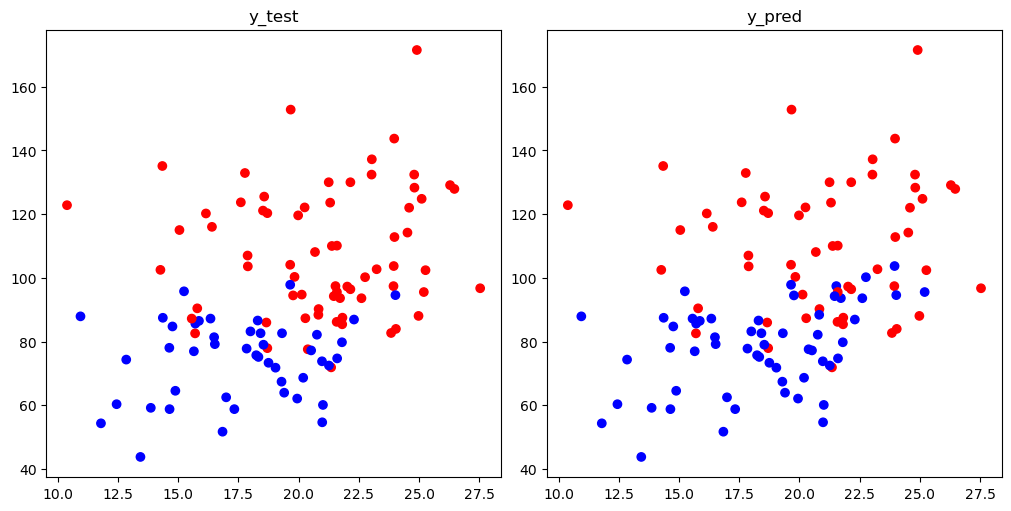

In [7]:
fig, ax = plt.subplots(1,2,layout='constrained',figsize=(10,5))
ax[0].scatter(x_test[:,1].flatten(),x_test[:,2].flatten(),c=['blue' if b == 'B' else 'red' for b in y_test])
ax[0].set_title('y_test')
ax[1].scatter(x_test[:,1].flatten(),x_test[:,2].flatten(),c=['blue' if b == 'B' else 'red' for b in y_pred])
ax[1].set_title('y_pred')
plt.show()

In [8]:
# Examine different values of k

f1s = []
accuracies = []
recalls = []
preds = []
precisions = []
ks = range(1, 11)
for k in ks:
    knn = KNearestNeighbors(x_train, y_train, k=k)
    preds += [knn.predict(x_test)]
    accuracies += [knn.accuracy(y_test)]
    f1s += [knn.f1(y_test)]
    recalls += [knn.recall(y_test)]
    precisions += [knn.precision(y_test)]

Text(0, 0.5, 'Precision')

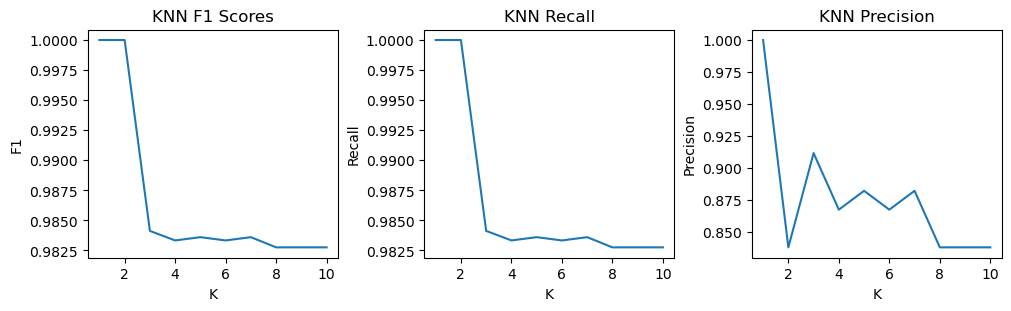

In [9]:
fig,axs = plt.subplots(1,3,layout='constrained',figsize=(10,3))

axs[0].plot(ks, f1s)
axs[0].set_title('KNN F1 Scores')
axs[0].set_xlabel('K')
axs[0].set_ylabel('F1')

axs[1].plot(ks, recalls)
axs[1].set_title('KNN Recall')
axs[1].set_xlabel('K')
axs[1].set_ylabel('Recall')

axs[2].plot(ks, precisions)
axs[2].set_title('KNN Precision')
axs[2].set_xlabel('K')
axs[2].set_ylabel('Precision')

In [22]:
# Examine across k-folds

t = time.process_time()


accuracies = []
recalls = []
f1s = []
preds = []
rocs = []

for i in np.arange(5):

    # define folds
    x_train = np.array_split(X.values,5)
    y_train = np.array_split(y.values,5)

    x_test, y_test = x_train.pop(i), y_train.pop(i).flatten()
    x_train, y_train = np.concatenate(x_train), np.concatenate(y_train)

    # run algorithm and eval
    knn = KNearestNeighbors(x_train, y_train, k=2)
    preds += [knn.predict(x_test)]
    accuracies.append(knn.accuracy(y_test))
    recalls.append(knn.recall(y_test))
    f1s.append(knn.f1(y_test))
    rocs += [roc_auc_score((y_test == 'B'),(preds[i]=='B'))]

print(time.process_time() - t)

0.08686600000000055


In [23]:
print(np.average(accuracies),np.average(recalls),np.average(f1s),np.average(rocs))

0.9086166744294364 0.940014652014652 0.940014652014652 0.892544894904104


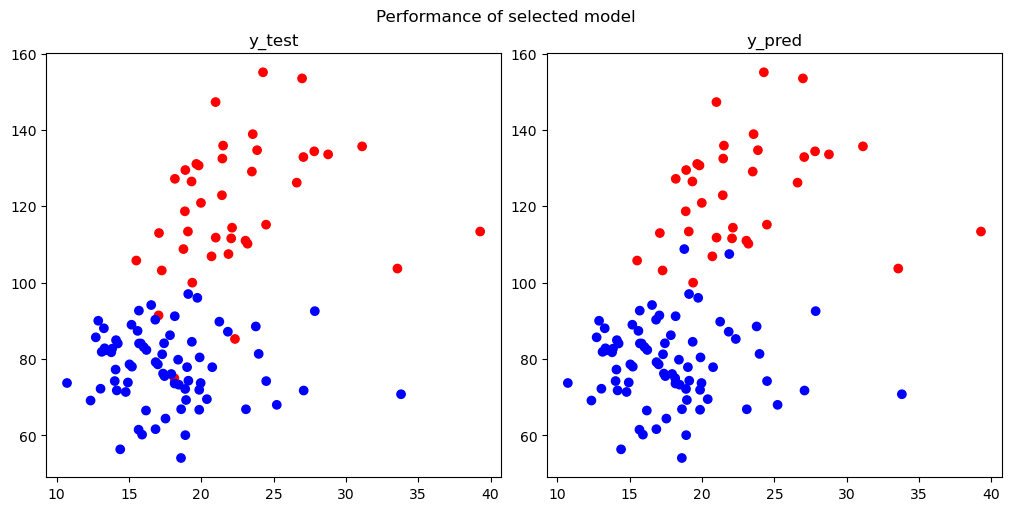

In [13]:
x_train = np.array_split(X.values,5)
y_train = np.array_split(y.values,5)
x_test, y_test = x_train.pop(2), y_train.pop(2).flatten()
x_train, y_train = np.concatenate(x_train), np.concatenate(y_train)

fig, ax = plt.subplots(1,2,layout='constrained',figsize=(10,5))
ax[0].scatter(x_test[:,1].flatten(),x_test[:,2].flatten(),c=['blue' if b == 'B' else 'red' for b in y_test])
ax[0].set_title('y_test')
ax[1].scatter(x_test[:,1].flatten(),x_test[:,2].flatten(),c=['blue' if b == 'B' else 'red' for b in preds[2]])
ax[1].set_title('y_pred')
fig.suptitle('Performance of selected model')
plt.show()

In [ ]:
# AUC curve

import sklearn as sk

sk.metrics.roc_curve(preds[2],)


In [ ]:
# Nominated model: k=2